In [1]:
# To ignore warnings

import os, warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess the COVID-19 dataset

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv" # URL for the COVID-19 dataset
df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Country/Region'] == 'US']
df.fillna(0, inplace=True)

In [4]:
# Feature engineering

df['New_Cases'] = df['Confirmed'].diff().fillna(0)

In [5]:
# Trim the data into specific range

start_date = pd.Timestamp('2020-03-01')
end_date = pd.Timestamp('2020-03-21')
df_train = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [6]:
df = df_train

In [7]:
# Define the training and testing set

train_size = int(len(df) * 0.8)
train_data = df['New_Cases'][:train_size]
test_data = df['New_Cases'][train_size:]

In [10]:
# Detrending the time series using differencing

train_data_diff = train_data.diff().dropna()
test_data_diff = test_data.diff().dropna()

In [495]:
# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(np.array(train_data_diff).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data_diff).reshape(-1, 1))

In [496]:
# Function to create sequences of data for training and testing

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [497]:
# Create sequences for training and testing

time_step = 2 # Number of days to look back
X_train, y_train = create_sequences(scaled_train, time_step)
X_test, y_test = create_sequences(np.concatenate((scaled_train[-time_step:], scaled_test)), time_step)

In [498]:
# Reshaping the data for the model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [499]:
# Define and compile the model as mentioned in Table 4

input_layer = Input(shape=(time_step, 1))
x = TimeDistributed(Dense(128))(input_layer)
x = MultiHeadAttention(num_heads=4, key_dim=8)(x, x)
x = LayerNormalization()(x)
x = Dropout(0.2)(x)
x = TimeDistributed(Dense(16, activation='relu'))(x)
x = GlobalAveragePooling1D()(x)
output_layer = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [500]:
# Define callbacks for training

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [501]:
# Train the model

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2659 - val_loss: 0.3641 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0589 - val_loss: 0.3574 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0700 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0739 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0582 - val_loss: 0.3647 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0500 - val_loss: 0.4376 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0520 - val_loss: 0.4371 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0477 - val_loss: 0.4436 - learning_rate: 2.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0526 - val_loss: 0.4624 - learning_rate: 2.0000e-04
Epoch 10/100
1/1 ━━━━━

In [502]:
# Make predictions and inverse transform the results

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


In [503]:
# Inverse transform the predictions to the original scale

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [504]:
# Fetch the actual future new cases for comparison

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
df_test = pd.read_csv(url)

df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test[df_test['Country/Region'] == 'US']
df_test.fillna(0, inplace=True)

df_test['New_Cases'] = df_test['Confirmed'].diff().fillna(0)

start_date = pd.Timestamp('2020-03-22')
end_date = pd.Timestamp('2020-03-24')
df_test = df_test[(df_test['Date'] >= start_date) & (df_test['Date'] <= end_date)]

actual_future_cases = df_test['New_Cases'].values

In [505]:
next = 3  # Number of days to forecast

In [506]:
# Prepare the input for future predictions

future_inputs = df['New_Cases'][-time_step:].values.reshape(1, time_step, 1)
future_predictions = []

for _ in range(next):
    future_pred = model.predict(future_inputs)
    future_predictions.append(future_pred[0, 0])
    future_inputs = np.append(future_inputs[:, 1:, :], future_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the future predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [507]:
future_predictions

array([[2327.3748],
       [2059.463 ],
       [1523.627 ]], dtype=float32)

In [508]:
# Invert the differencing for future predictions

last_value = df['New_Cases'].iloc[-1]
future_predictions_orig = last_value + np.cumsum(future_predictions)

In [509]:
future_predictions_orig

array([ 8322.375, 10381.838, 11905.465], dtype=float32)

In [510]:
# Evaluate the predictions

rmse = np.sqrt(mean_squared_error(actual_future_cases, future_predictions_orig))
mape = mean_absolute_percentage_error(actual_future_cases, future_predictions_orig)

print(f'Root Mean Squared Error for Transformer: {rmse}')
print(f'Mean Absolute Percentage Error for Transformer: {mape}')

Root Mean Squared Error for Transformer: 932.1439068502534
Mean Absolute Percentage Error for Transformer: 0.08573573452633822


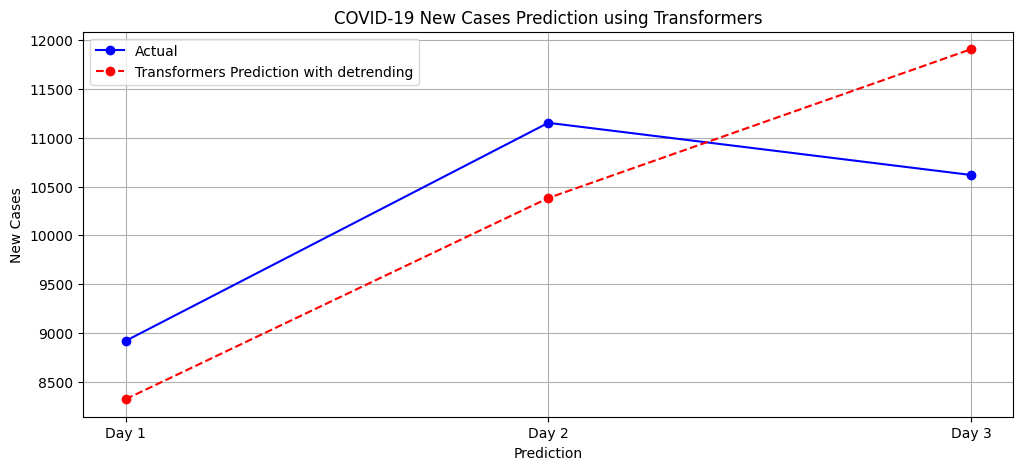

In [515]:
# Visualize the predictions as shown in Figure 8

days = ["Day 1", "Day 2", "Day 3"]
actual_new_cases = actual_future_cases
predicted_new_cases = future_predictions_orig

plt.figure(figsize=(12, 5))

plt.plot(days, actual_new_cases, marker='o', linestyle='-', color='blue', label='Actual')
plt.plot(days, predicted_new_cases, marker='o', linestyle='--', color='red', label='Transformers Prediction with detrending')

plt.title('COVID-19 New Cases Prediction using Transformers')
plt.xlabel('Prediction')
plt.ylabel('New Cases')

plt.legend()

plt.grid(True)
plt.show()